### Initial tokenising and feature engineering of the dataset

-- Merged train dataset: tweet_train_complete
-- Merged train dataset Pickled: tweet_train_complete_PICKLE

-- Merged test dataset: tweet_test_complete
-- Merged test dataset Pickled: tweet_test_complete_PICKLE

### Import python packages

In [1]:
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize, wordpunct_tokenize
from nltk.corpus import stopwords
from nltk import pos_tag, word_tokenize
import string
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks, EditedNearestNeighbours
from imblearn.combine import SMOTETomek, SMOTEENN
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.decomposition import PCA, SparsePCA, TruncatedSVD
from sklearn.linear_model import LogisticRegression,SGDClassifier 
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import accuracy_score, f1_score, classification_report
import spacy
import _pickle as pickle
import timeit
import re

### Load the pickled datasets 

In [2]:
def pickleloader(filename):
    # # open the file for writing
    fileObject = open(filename,'rb') 

    # load the object from the file into var univ_processed_train
    return pickle.load(fileObject,  encoding="latin1")  #latin1 here, to bypass 
                                        # python2 to 3 pickle problem

    # here we close the fileObject
    fileObject.close()

In [3]:
file_Name_train = "tweet_train_complete_textnonull_PICKLE"
file_Name_test = "tweet_test_complete_textnonull_PICKLE"

train_complete = pickleloader(file_Name_train)
test_complete = pickleloader(file_Name_test)

In [4]:
#join the train and test sets together 
traintest_complete = pd.concat([train_complete,test_complete])

In [5]:
# extracted only the RELATED rows 
traintest_complete_REL = traintest_complete[traintest_complete.filtering=="RELATED"]

In [6]:
universitylist = ["RL2013D03E086", "RL2013D03E087", "RL2013D03E088", "RL2013D03E089", "RL2013D03E090", 
                  "RL2013D03E091", "RL2013D03E093", "RL2013D03E096", "RL2013D03E097", "RL2013D03E124"] 

musiclist = ["RL2013D04E145", "RL2013D04E146", "RL2013D04E149", "RL2013D04E151", "RL2013D04E152", "RL2013D04E153", 
           "RL2013D04E155", "RL2013D04E159", "RL2013D04E161", "RL2013D04E162", "RL2013D04E164", "RL2013D04E166", 
           "RL2013D04E167", "RL2013D04E169", "RL2013D04E175", "RL2013D04E185", "RL2013D04E194", "RL2013D04E198", 
           "RL2013D04E206", "RL2013D04E207"] 

SATask_masterlist = universitylist + musiclist

In [7]:
SATask_master = traintest_complete_REL[traintest_complete_REL.entity_id.isin(SATask_masterlist)].copy()

In [8]:
SATask_master.polarity.unique()

array(['NEUTRAL', 'POSITIVE', 'NEGATIVE', 'RELATED'], dtype=object)

In [9]:
SATask_master[SATask_master["polarity"]=="RELATED"]

,tweet_id,author,entity_id,text,filtering,polarity,topic,topic_priority
40361,216287162696605696,katita048,RL2013D04E169,Wisin & Yandel - Follow The Leader ft. Jennife...,RELATED,RELATED,neutral,NEUTRAL
40362,218086720443400192,isamarfernande,RL2013D04E169,Wisin & Yandel - Follow The Leader ft. Jennife...,RELATED,RELATED,neutral,NEUTRAL


In [10]:
SATask_master.drop(index=[40361, 40362],inplace=True)

In [11]:
# write a function that determines whether a sentence is 
def is_it_this_language(textsource, tokeniser, languages):
    #textsource, lDF, variable name of the the dataframe holding the sentence/document to be tokensized. if source is 
        # in a list, pass the list through pd.Dataframe() beforehand
    #tokeniser, function name, this is the tokeniser to be used... this function is written to work with NLTK's word_tokenize, wordpunct_tokenize
    #language, list, the language(s) to be checked for. NLTK's language are lowercase, full words e.g. "english". 
    
    it_is_this_language = {}
    for i in list(textsource.index):
        tokenised = tokeniser(textsource[i])
        tokens = [token.lower() for token in tokenised]
        tokens_set = set(tokens)
        languages_ratios = {}

        for lang in languages: 
            stopwords_set = set(stopwords.words(lang))
            common_elements = tokens_set.intersection(stopwords_set)
            languages_ratios[lang] = len(common_elements) #appends the number of tokens in the text that falls 
                                                              #in each of the NLTK's stop words.   
        it_is_this_language[i] = max(languages_ratios, key=languages_ratios.get)
    return it_is_this_language

# run the function with a timer. languages to be used are English and Spanish. This is due to the manner in which the 
# dataset was collected. 
start = timeit.timeit()
languages_input = ["english", "spanish"]
language = is_it_this_language(SATask_master.text, wordpunct_tokenize,languages_input)
end = timeit.timeit()
print (end - start)

SATask_master["tweet_lang"] = language.values()

-0.004077091005456168


In [12]:
SATask_eng = SATask_master[SATask_master.tweet_lang=="english"].copy()
SATask_eng.shape

(44182, 9)

In [13]:
SATask_eng.polarity.unique()

array(['NEUTRAL', 'POSITIVE', 'NEGATIVE'], dtype=object)

In [14]:
def picklemaker(filename, objectname): 
    # open the file for writing
    fileObject = open(filename,'wb') 

    # this writes the object a to the
    # file named 'testfile'
    pickle.dump(objectname,fileObject)   

    # here we close the fileObject
    fileObject.close()

In [15]:
def spacyadjadv(tweettext):
    text = spacynlp(tweettext)
    adjadvlist=[]
    for token in text: 
        if token.pos_ in ["ADJ", "ADV"]:
            adjadvlist.append(token.text.lower())
    return adjadvlist

In [ ]:
picklemaker("1. SATask_eng", SATask_eng)

In [17]:
SATask_eng = pickleloader('1. SATask_eng')

In [18]:
# write functions that uses regex to preprocess the tweet texts in the same manner as the Stanford GloVe Twitter set
# https://nlp.stanford.edu/projects/glove/preprocess-twitter.rb | neutralface and ALLCAPS are left out as they are 
# ambiguous 
# apply all these function first (such that # and @ can be used to locate these features. 
# followed by a final removal of special characters.  


def tweetprocessorfuncs(tweettext):
    tweettext = re.sub(r"http\B\S+|www\.\B\S+|\S+\.\w+", ' <URL> ', tweettext)
    tweettext = re.sub(r"(@|@\B)\w+", ' <USER> ', tweettext)
    tweettext = re.sub(r'\s(\+|-)*\d+\b', " <NUMBER> ", tweettext) # slight difference from the GloVe treatment which also replaces +-
                                                      # hypothesis is that +- numbers do not serve as signal for sentiment
                                                        # only change numbers that start and end with whitespace. we don't
                                                        # want to replace instances such as test123
    tweettext = re.sub(r'(#|#\B)\w+', " <HASHTAG> ", tweettext)
    tweettext = re.sub(r'(([!.]){2,})', '! <REPEAT> ', tweettext) # replace multiple !!! with ! and <REPEAT>. i.e. new feature
    tweettext = re.sub(r'(([?.]){2,})', '? <REPEAT> ', tweettext) # replace multiple ??? with ? and <REPEAT>. i.e. new feature
    tweettext = re.sub(r"(8|:|=|;)('|`|-)?\){1,2}", " <SMILE> ", tweettext)
    fm = re.sub(r"(8|:|=|;)('|`|-)?(P|p|D){1,3}", " <LOLFACE> ", tweettext) # slight difference from the GloVe
                                                                                    # treatment... catches :p and :d
    tweettext = re.sub(r"(8|:|=|;)('|`|-)?\({1,2}", " <SADFACE> ", tweettext)
    tweettext = re.sub(r"<3{1,}", " <HEART> ", tweettext)
    tweettext = re.sub(r'(\S*?)\B(.)\2{2,}\b', r'\1' + r'\2' + ' <ELONG> ', tweettext)
    tweettext = re.sub(r'(([A-Z]){7,}\B)', ' <ALLCAPS> ' + r'\1', tweettext) # regex for tokens composed of a sequence of
                                                                        # 7 or more capitalised alphabets. 7 because it
                                                                        # is unlikely to be a acronym (e.g. UNICEF)

    return tweettext

SATask_eng.text = SATask_eng.text.apply(tweetprocessorfuncs)

In [19]:
# write a function that uses regex to remove remaining @ # and other special characters as well as english stop words. 

specialchars = re.compile('[^0-9a-z ?!<>+_]') # the GloVe Twitter set left ! and ? in place. we replicate the same 
                                              # to preserve any associated semantic pattern  
stopwords_list = set(stopwords.words('english')) #using NLTK's english stopwords

entity_names =["bmw", "audi", "volvo", "toyota", "volkswagen", "honda", "nissan", "fiat", "suzuki", "porsche",
              "yamaha", "mazda", "chrysler", "subaru", "ferrari", "bentley", "kia", "ford", "jaguar", "lexus",
              "barclays", "fargo", "wellsfargo", "bankia", "santander", "goldman", "harvard", "standford", 
              "berkeley", "princeton", "columbia", "yale", "hopkins", "johnhopkins", "oxford", "adele", "aliciakeys", 
               "alicia","beatles", "zeppelin", "aerosmith", "bonjovi", "jovi", "acdc", "thewanted", "coldplay", 
               "ladygaga","gaga", "madonna", "jennifer", "lopez", "jeniferlopez", "bieber", "justinbieber", "shakira", "psy",
              "whitneyhouston", "whitney", "houston", "britneyspears", "britney", "spears"]

for i in entity_names: 
    stopwords_list.add(i)

def finaltweetclean(tweettext):
    tweettext = tweettext.lower() # lowercase text
    tweettext = re.sub("  ", " ", tweettext) # delete double spaces
    tweettext = re.sub("  ", " ", tweettext) # delete double spaces
    tweettext = re.sub("  ", " ", tweettext) # delete double spaces
    tweettext = re.sub("  ", " ", tweettext) # delete double spaces
    tweettext = re.sub(specialchars, "", tweettext) # delete symbols which are in specialchars from text
    tweettext = ' '.join([i for i in tweettext.split() if i not in stopwords_list]) # delete stopwords from text
    return tweettext

SATask_eng.text = SATask_eng.text.apply(finaltweetclean)

In [ ]:
text_adjadv_list = []
for i in SATask_eng.index: 
    text_adjadv_list.append([SATask_eng.loc[i,"adjadvlist"], SATask_eng.loc[i,"text"]])
    
SATask_eng["text_adjadv"] = text_adjadv_list

##### Use gensim to load the GloVe Twitter trained vectors

In [20]:
import gensim
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec # for calling glove2word2vec script

In [ ]:
# # the GloVe format is not aligned for use with gensim. The following gensim script automatically converts it and 
# # loads it. 

# glove_file = ('./2. Trained models/1. glove.twitter.27B/glove.twitter.27B.100d.txt')
# tmp_file = get_tmpfile("glove_word2vec.txt")
# # default way (through CLI): python -m gensim.scripts.glove2word2vec --input <glove_file> --output <w2v_file>
# glove2word2vec(glove_file, tmp_file)

# glove_twitter = KeyedVectors.load_word2vec_format(tmp_file)

In [23]:
## pickiling the GloVe Twitter dataset
# def picklemaker(filename, objectname): 
#     # open the file for writing
#     fileObject = open(filename,'wb') 

#     # this writes the object a to the
#     # file named 'testfile'
#     pickle.dump(objectname,fileObject)   

#     # here we close the fileObject
#     fileObject.close()
# filename = "1. DATA_SATask_GloVe_Twitter_PICKLE_100D"
# picklemaker(filename, glove_twitter)

# loading the pickled GloVe Twitter dataset
filename_glove = '1. DATA_SATask_GloVe_Twitter_PICKLE_100D'
glove_twitter = pickleloader(filename_glove)

##### Considering POS: Giving a weight to the vectors of tokens that are ADJs and ADJs in the tweet

In [19]:
# write a function that (i) checks whether each of the token in a single tweet is in the Twitter-trained 200D GloVe set.
# (ii) if not, input a matrix of the same embedding size - (200,1) in this case -
spacynlp = spacy.load("en_core_web_sm")

def paravectorPOS(text): 
    word_list = []
    if True in [i in glove_twitter.index2entity for i in text.split()]: 
        for i2 in text.split(): 
            if i2 in glove_twitter.index2entity:
                spacy_adjadv_list = [token.text for token in spacynlp(text) if token.pos_ in ["ADJ","ADV"]]
                if i2 in spacy_adjadv_list:
                    word_list.append(glove_twitter.get_vector(i2)**3) 
                else: 
                    word_list.append(glove_twitter.get_vector(i2))  
    else:
        word_list.append(np.zeros_like(glove_twitter.get_vector("the"))+0.1) 
    return sum(word_list)/len(word_list)

# for tweets with no tokens in the GloVe Twitter embeddings, we impute a similar sized vector of 0.01s. a check of 
# shows that the most similar words to this vectors are infrequent words and do not hold significant meaning for sentiment. 
# glove_twitter.similar_by_vector(np.zeros_like(glove_twitter.get_vector("the")+0.01))
# [('bitmeye', 0.0),
#  ('bispa', 0.0),
#  ('bosanma', 0.0),
#  ('bordões', 0.0),
#  ('bookmarklet', 0.0),
#  ('boncabe', 0.0),
#  ('bocs', 0.0),
#  ('bloked', 0.0),
#  ('boyet', 0.0),
#  ('bilmeyi', 0.0)]

In [70]:
# write a function that (i) checks whether each of the token in a single tweet is in the Twitter-trained 200D GloVe set.
# (ii) if not, input a matrix of the same embedding size - (200,1) in this case -
def paravectorPOS2(text): 
    word_list = []
    if True in [i in glove_twitter.index2entity for i in text[1].split()]: 
        for i in text[1].split(): 
            if i in glove_twitter.index2entity:
                if i in text[0]:
                    word_list.append(glove_twitter.get_vector(i)**3) 
                else: 
                    word_list.append(glove_twitter.get_vector(i))  
    else:
        word_list.append(np.zeros_like(glove_twitter.get_vector("the"))+0.1) 
    return sum(word_list)/len(word_list)

# for tweets with no tokens in the GloVe Twitter embeddings, we impute a similar sized vector of 0.01s. a check of 
# shows that the most similar words to this vectors are infrequent words and do not hold significant meaning for sentiment. 
# glove_twitter.similar_by_vector(np.zeros_like(glove_twitter.get_vector("the")+0.01))
# [('bitmeye', 0.0),
#  ('bispa', 0.0),
#  ('bosanma', 0.0),
#  ('bordões', 0.0),
#  ('bookmarklet', 0.0),
#  ('boncabe', 0.0),
#  ('bocs', 0.0),
#  ('bloked', 0.0),
#  ('boyet', 0.0),
#  ('bilmeyi', 0.0)]

In [128]:
# using the paravectorPOS function (i.e. taking into consideration PoS and giving higher weights to adj and adverbs)
allparavectors = [] #empty list to append each tweets DF (containing summed GloVe)
for k in SATask_eng["text_adjadv"]:  # 
    allparavectors.append(pd.DataFrame(paravectorPOS2(k)).T) 
    
X_SATask_eng_GloVe = pd.concat(allparavectors,axis=0) #concat the GloVe-ed dataframes for each tweet
X_SATask_eng_GloVe.index = SATask_eng.index #restore the SATask_eng index to the new dataframe

##### Without considering POS 

In [ ]:
# # write a function that (i) checks whether each of the token in a single tweet is in the Twitter-trained 200D GloVe set.
# # (ii) if not, input a matrix of the same embedding size - (200,1) in this case -
# def paravector(text): 
#     word_list = []
#     if True in [i in glove_twitter.index2entity for i in text.split()]: 
#         for i2 in text.split(): 
#             if i2 in glove_twitter.index2entity:
#                 word_list.append(glove_twitter.get_vector(i2))  
#     else:
#         word_list.append(np.zeros_like(glove_twitter.get_vector("the"))+999)
#         word_list.append(np.zeros_like(glove_twitter.get_vector("the"))+999)                      
#     return sum(word_list)/len(word_list)

In [ ]:
# allparavectors = [] #empty list to append each tweets DF (containing summed GloVe)
# for k in SATask_eng.text:  # 
#     allparavectors.append(pd.DataFrame(paravector(k)).T) 
    
# X_SATask_eng_GloVe = pd.concat(allparavectors,axis=0) #concat the GloVe-ed dataframes for each tweet
# X_SATask_eng_GloVe.index = SATask_eng.index #restore the SATask_eng index to the new dataframe

##### Pickling (or unpickling the GloVE vectors for the tweets)

In [129]:
def picklemaker(filename, objectname): 
    # open the file for writing
    fileObject = open(filename,'wb') 

    # this writes the object a to the
    # file named 'testfile'
    pickle.dump(objectname,fileObject)   

    # here we close the fileObject
    fileObject.close()

In [21]:
# # with POS considered - for pickling
# filename_ = "XV5CIV_SATask_eng_GloVe_PICKLE_100D_POS2_exp3"
# objectname_ = X_SATask_eng_GloVe
# picklemaker(filename_,objectname_)

# with POS considered - for loading
filename_ = "XV5CIV_SATask_eng_GloVe_PICKLE_100D_POS2_exp3"
X_SATask_eng_GloVe = pickleloader(filename_)

In [ ]:
## without POS considered - for picking 
# filename_ = "XV5CIV_SATask_eng_GloVe_PICKLE_100D"
# objectname_ = X_SATask_eng_GloVe
# picklemaker(filename_,objectname_)

# # without POS considered - for loading
# filename_ = "XV5CIV_SATask_eng_GloVe_PICKLE_100D"
# X_SATask_eng_GloVe = pickleloader(filename_)

In [24]:
X_SATask_eng_GloVe[X_SATask_eng_GloVe[0]==(glove_twitter.get_vector("the")[0]+0.1)].describe()

# there are 99 tweets that do not have tokens that fall within the Twitter-trained GloVe 200D word embeddings.
# as the number is not significantly large we leave these 99 tweets in the dataset 
# to provide signal to the model and manage overfitting. 

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### Train Test Split 

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X_SATask_eng_GloVe, SATask_eng.polarity, test_size=0.33, random_state=42)

In [26]:
X_train.index

Int64Index([34824, 25116, 23297, 81129, 80289, 37819, 83554, 65713, 70069,
            72012,
            ...
            50146, 95586, 63878, 85121, 52282, 33208, 40024, 86373, 23674,
            49843],
           dtype='int64', length=29601)

In [27]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test) #transform using the earlier fit. 

##### The count for the "NEGATIVE" class is significantly lower than "POSITIVE". Use SMOTE to upsample the "NEGATIVE" class. 

In [28]:
sm = SMOTE(ratio="minority", random_state=42, n_jobs=-1, k_neighbors=5, m_neighbors=50) 
# , enn=EditedNearestNeighbours(n_neighbors=5, n_jobs=-1)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)
X_train_res.shape

(47032, 100)

#### Running a pipeline with GridSearch CV to find the best performing classifier

In [ ]:
est_names = ["rfClass", "sgdClass", 'decisiontree']

estimators = [RandomForestClassifier(random_state=42), 
              SGDClassifier(random_state=42, n_jobs=-1),DecisionTreeClassifier(random_state=42)] 
              
parameters = [
    {est_names[0]+'__n_estimators': np.arange(10, 51,10)},
    {est_names[1]+'__loss': ('hinge', 'log', 'modified_huber'), 
     est_names[1]+'__penalty': ('l1','l2', 'elasticnet'),
     est_names[1]+'__alpha': ([10 ** x for x in range(-6, -2)]),
     est_names[1]+'__tol' : ([10 ** x for x in range(-4, -2)]),
     est_names[1]+'__max_iter':(np.arange(100, 300, 50))},
    {est_names[2]+'__criterion': ("gini", "entropy"),
     est_names[2]+'__max_depth': (range(3,6,1)), 
     est_names[2]+'__max_features' : (np.arange(0.5,1.01,0.25))}
             ]

# for RFCLass, we don't limit max depth... 
# for TFIDF normalisation read 2.2.3 of https://nlp.stanford.edu/IR-book/pdf/irbookonlinereading.pdf
# for TFIDF sublinear_tf = True is necessary because it provides smoothing. 
# for SparsePCA read https://gawalt.com/brian/resources/TextEDAviaSparsePCA.pdf

gridsearch_models = []
for est_name, estimator, param in zip(est_names, estimators, parameters):
    pipe =  Pipeline([(est_name, estimator)])
    pipe_GS = GridSearchCV(pipe,param_grid=param, n_jobs=-1, cv=3)
    clf = pipe_GS.fit(X_train_res , y=y_train_res)
    gridsearch_models.append(clf)
    pipe_GS_cvs_train = cross_val_score(clf, X_train_res, y=y_train_res)
    pipe_GS_cvs_test = cross_val_score(clf, X_test, y=y_test)
    pipe_GS_cr = classification_report(y_test, clf.predict(X_test))                 
    print(est_name, "\n\n", \
           "train cross val score: ", "\n", pipe_GS_cvs_train, "\n\n",
           "test cross val score: ", "\n", pipe_GS_cvs_train, "\n\n",
           "class report - test set: ", "\n", pipe_GS_cr)  


In [ ]:
gridsearch_models

#### Result of best-tuned Random Forest Classifier

In [29]:
clf = RandomForestClassifier(n_estimators=100,random_state=42, oob_score=True, n_jobs=-1)
clf_model = clf.fit(X_train_res, y_train_res)

In [30]:
LogReg_cvs_train = cross_val_score(clf_model, X_train_res, y=y_train_res)
LogReg_cvs_test = cross_val_score(clf_model, X_test, y=y_test)
LogReg_cr = classification_report(y_test, clf_model.predict(X_test))

In [31]:
print("RFClass 100 estimators", "\n\n", \
           "train cross val score: ", "\n", LogReg_cvs_train, "\n\n",
           "test cross val score: ", "\n", LogReg_cvs_test, "\n\n",
           "class report - test set: ", "\n", LogReg_cr) 

RFClass 100 estimators 

 train cross val score:  
 [0.80431177 0.81782229 0.81846016] 

 test cross val score:  
 [0.70808476 0.7041761  0.70755299] 

 class report - test set:  
              precision    recall  f1-score   support

   NEGATIVE       0.29      0.41      0.34      1127
    NEUTRAL       0.79      0.17      0.28      3588
   POSITIVE       0.75      0.93      0.83      9866

avg / total       0.72      0.70      0.66     14581



In [138]:
filename_model = "RFC_model_with_POS2_exp3"
objectname_model = clf_model
picklemaker(filename_model,objectname_model)

#### 'Live' testing the best-performing Random Forest Classifier mode 

In [82]:
testlist = [test1,test2,test3,test4,test5,test6,test7,test8,test9]

In [106]:
test1 = "Who could have a terrible time at Adele's birthday party?"
#https://twitter.com/Magic1053SA/status/995831877427744768

test2 = "United Airlines - thank you Captains and crew for being so gracious. 🤟 "
# https://twitter.com/genesimmons/status/996558994511749120

test3 = "Hey guess where I am? Delayed on another @united flight! Worst Big3 airline continues its track record of fails after fails. #UnitedAirlines #FintheAbyUnited"
# https://twitter.com/seanmichaelfeld/status/995816983240347648

test4 = "Got royally fucked by @united. Canceled our flight from Chicago to Ottawa completely. No room on any flights today. Claim it was air traffic control issue. Were already on plane, and our pilot was an hour late, THEN it got canceled. Then they started claiming it was weather..."
# https://twitter.com/bdunkelman/status/996516552676728832

test5 = "Don’t understand why airlines lie about delay times. @united the departure time is listed as 7:20est. It is 7:15 and still haven’t boarded. Give us a chance to make alt plans but that would require caring about customers."
# https://twitter.com/thedrake09/status/996529741514592257

test6 = "Entrance to the new @BestWestern Plus in Bole Medhane Alem, Addis Ababa, #Ethiopia. 🇪🇹"
# https://twitter.com/PositivelyEthio/status/993732385232637953

test7 = "Thank you to @BestWestern for playing along with the stupid goof I did when we were planning the Modesto trip! "
# https://twitter.com/MarioBrosMinute/status/991820396562272256

test8 = "#SunnySideOfLife: Pristine white sandy beaches, crystal clear lagoons filled with blood of its citizens who r fightin 4democracy 100% Maldives"
# https://twitter.com/Naibuthuthu1/status/223372021587910656

test9 = "#SunnySideOfLife : Where uniformed criminals walk free after brutalizing civilians, but democracy activists get harassed for 'witchcraft'"
# https://twitter.com/yaamyn/status/223318584078766082

for i in testlist:
    print (i, "\n", 
           clf_model.predict(paravectorPOS2(i).reshape(1,-1)))

Who could have a terrible time at Adele's birthday party? 
 ['POSITIVE']
United Airlines - thank you Captains and crew for being so gracious. 🤟  
 ['POSITIVE']
Hey guess where I am? Delayed on another @united flight! Worst Big3 airline continues its track record of fails after fails. #UnitedAirlines #FintheAbyUnited 
 ['POSITIVE']
Got royally fucked by @united. Canceled our flight from Chicago to Ottawa completely. No room on any flights today. Claim it was air traffic control issue. Were already on plane, and our pilot was an hour late, THEN it got canceled. Then they started claiming it was weather... 
 ['NEGATIVE']
Don’t understand why airlines lie about delay times. @united the departure time is listed as 7:20est. It is 7:15 and still haven’t boarded. Give us a chance to make alt plans but that would require caring about customers. 
 ['NEGATIVE']
Entrance to the new @BestWestern Plus in Bole Medhane Alem, Addis Ababa, #Ethiopia. 🇪🇹 
 ['POSITIVE']
Thank you to @BestWestern for playi

### Visualising the negative and positive tweets on the vector space.

In [46]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

def tsne_plot2(model, searchword1, searchword2):
    "Creates and TSNE model and plots it"
    labels1 = []
    tokens1 = []

    labels2 = []
    tokens2 = []
    
    for word1 in [x11[0] for x11 in glove_twitter.similar_by_word(searchword1)]:
        tokens1.append(model[word1])
        labels1.append(word1)
        
    for word2 in [x22[0] for x22 in glove_twitter.similar_by_word(searchword2)]:
        tokens2.append(model.get_vector(searchword1) - model.get_vector(word2))
        labels2.append(word2)
    
    tsne_model1 = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values1 = tsne_model1.fit_transform(tokens1)

    tsne_model2 = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values2 = tsne_model2.fit_transform(tokens2)
    
    x1 = []
    y1 = []
    
    x2 = []
    y2 = []
    
    for value1 in new_values1:
        x1.append(value1[0])
        y1.append(value1[1])
    
    for value2 in new_values2:
        x2.append(value2[0])
        y2.append(value2[1])
    
    plt.figure(figsize=(7, 7)) 
    for i1 in range(len(x1)):
        plt.scatter(x1[i1],y1[i1],c="#C14821")
        plt.annotate(labels1[i1],
                     xy=(x1[i1], y1[i1]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
        
    for i2 in range(len(x2)):
        plt.scatter(x2[i2],y2[i2],c="#107DC3")
        plt.annotate(labels2[i2],
                     xy=(x2[i2], y2[i2]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')    
    plt.show()

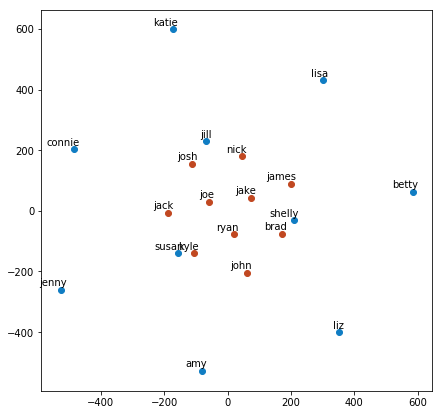

In [47]:
tsne_plot2(glove_twitter, "tom", "sally")

In [49]:
postweet_samp_index = SATask_eng[SATask_eng.polarity=="POSITIVE"].tail(50).index
negtweet_samp_index = SATask_eng[SATask_eng.polarity=="NEGATIVE"].tail(50).index
neutraltweet_samp_index = SATask_eng[SATask_eng.polarity=="NEUTRAL"].tail(50).index

In [50]:
postweet_samp_vects = X_SATask_eng_GloVe.loc[postweet_samp_index].copy()
negtweet_samp_vects = X_SATask_eng_GloVe.loc[negtweet_samp_index].copy()
neutraltweet_samp_vects = X_SATask_eng_GloVe.loc[neutraltweet_samp_index].copy()

In [104]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

def tsne_plot4(sample1, samplelabel1, sample2, samplelabel2, sample3, samplelabel3):
    "Creates and TSNE model and plots it"
    labels1 = []
    tokens1 = []

    labels2 = []
    tokens2 = []
    
    labels3 = []
    tokens3 = []
    
    for row1 in sample1.index:
        tokens1.append(np.asarray(sample1.loc[row1]))
        labels1.append(samplelabel1)
        
    for row2  in sample2.index:
        tokens2.append(np.asarray(sample2.loc[row2]))
        labels2.append(samplelabel2)
        
    for row3  in sample3.index:
        tokens3.append(np.asarray(sample3.loc[row3]))
        labels3.append(samplelabel3)
    
    tsne_model1 = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values1 = tsne_model1.fit_transform(tokens1)

    tsne_model2 = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values2 = tsne_model2.fit_transform(tokens2)
    
    tsne_model3 = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values3 = tsne_model3.fit_transform(tokens3)
    
    x1 = []
    y1 = []
    
    x2 = []
    y2 = []
    
    x3 = []
    y3 = []
    
    for value1 in new_values1:
        x1.append(value1[0])
        y1.append(value1[1])
    
    for value2 in new_values2:
        x2.append(value2[0])
        y2.append(value2[1])
        
    for value3 in new_values3:
        x3.append(value3[0])
        y3.append(value3[1])
    
    plt.figure(figsize=(15, 15))
    for i1 in range(len(x1)):
        plt.scatter(x1[i1],y1[i1], c="#C14821")
        plt.annotate(labels1[i1],
                     xy=(x1[i1], y1[i1]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
        
    for i2 in range(len(x2)):
        plt.scatter(x2[i2],y2[i2],c="#107DC3")
        plt.annotate(labels2[i2],
                     xy=(x2[i2], y2[i2]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')    
        
        
    for i3 in range(len(x3)):
        plt.scatter(x3[i3],y3[i3],c="#7B8E4E")
        plt.annotate(labels3[i3],
                     xy=(x3[i3], y3[i3]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')    
    
    plt.show()

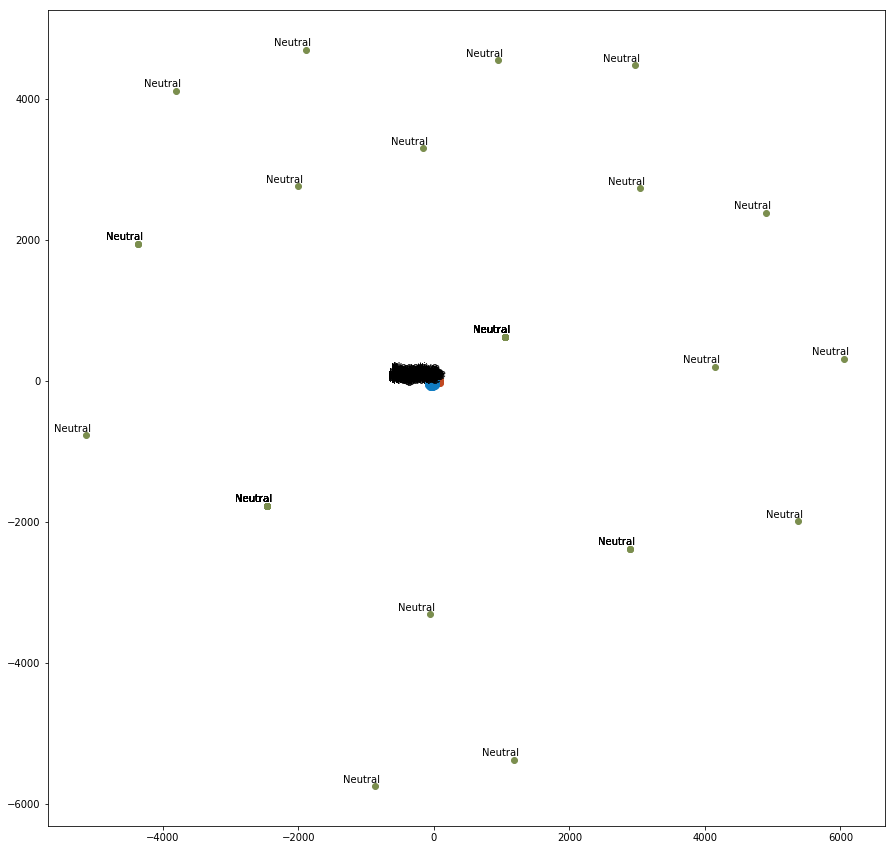

In [105]:
tsne_plot4(postweet_samp_vects, "Positive", negtweet_samp_vects, "Negative", neutraltweet_samp_vects, "Neutral")